In [1]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
from matplotlib import pyplot as plt

h_dir = os.getcwd()

### Step 1: Prepare text for future processing

In [2]:
# Create csv file with labels

text = open(h_dir + '/experimental_data')
raw_data = text.read().split(';')
for i in range(len(raw_data)):
    raw_data[i] = raw_data[i].split('\n')
    filter_obj = filter(lambda x: x!='', raw_data[i])
    raw_data[i] = list(filter_obj)
    
raw_data.pop(0)
    
# print(raw_data)

['№ Каталога', 'Опушение', 'Вегетация', 'Порядковый номер', 'Диплоиды']

### Step 2: Create dataframe to convert data in into csv using patterns of regex

In [3]:
def list_to_str(lst):
    res_str = ''
    for x in lst:
        res_str += x + ';'
    return res_str


df = pd.DataFrame({'Номер_каталога': [],
                   'Вид_злаков':[],
                   'Вид':[],
                   'Опушение':[],
                   'Вегетация':[],
                   'Порядковые_номера':[]
                  })

spec_patt = r'T\.\s\w*'
species = ''

ear_patt = r'([А-Я][а-я]*)'
ear_kind = 'Диплоиды'

veg_patt = ''
num_patt = ''
    
for x in raw_data:
    if not x:
        continue
    # in this case we consider only spicies of wheat and ear kinds (as you may see they are lists 1 lenght)
    if len(x) == 1:
        res = re.search(spec_patt, x[0])
        if res:
            species = res.group()
        else:
            res = re.search(ear_patt, x[0])
            if res:
                ear_kind = res.group()
    # otherways we consider specific species of wheat
    else:
        catalog_num = x[0]
        pubescence = 0
        veg = []
        ord_num = []
        if x[1] == '+':
            pubescence = 1
            
        # regex patterns to distinguish vegetation for order numbers
        veg_patt = r'(X|Х|I){1,2}-?\d{2}'
        ord_patt = r'\d{2,4}-?(\d{2,4})?'
        for i in [i+2 for i in range(len(x)-2)]:
            res = re.search(veg_patt, x[i])
            if res:
                veg.append(res.group())
            else:
                res = re.search(ord_patt, x[i])
                if res:
                    ord_num.append(res.group())
        # add data into dataframe
        df = df.append(pd.DataFrame({'Номер_каталога': [catalog_num],
                   'Вид_злаков':[ear_kind],
                   'Вид':[species],
                   'Опушение':[str(pubescence)],
                   'Вегетация':[list_to_str(veg)],
                   'Порядковые_номера':[list_to_str(ord_num)],
                  }))

# df ---> csv
df.to_csv('labels.csv', index=False)

In [4]:
tmp = df.loc[df['Порядковые_номера'].str.contains('7691-7700')]
# print(tmp.loc[tmp['Опушение'] == '0'])
print(df.loc[df['Вид'] == 'T. sphaerococcum' ])

  Номер_каталога   Вид_злаков               Вид Опушение Вегетация  \
0        к-14976  Гексаплоиды  T. sphaerococcum        1    II-18;   
0        к-33750  Гексаплоиды  T. sphaerococcum        0    II-18;   

  Порядковые_номера  
0          8451-60;  
0        8491-8500;  


### Step 3: Exploratory data analysis

In [5]:
df = pd.read_csv(h_dir + '/labels.csv')

print('Образцов с опушением:', len(df[df['Опушение'] == 1]))
print('Образцов без опушения:', len(df[df['Опушение'] == 0]) )

Образцов с опушением: 54
Образцов без опушения: 108


In [6]:
# Go through file system and calculate general num of images
pin_dir = r'/pin'
table_dir = r'/table'

def species_stats(dir_type):
    # define patterns for regexs
    ord_patt = r'\d{2,4}-?\d{0,4}?'
    spec_patt = r'T\.\s?[\w]+'
    img_patt = r'\d{2,4}(_\{[ХXI]{1,2}-?\d{2,4}\})?\.(jpg|JPG)$'
    if 'pin' in dir_type:
        img_patt = r'\d{2,4}_(([^,(I|l)]_\{[ХXI]{1,2}-?\d{2,4}\})|(\d{1}))\.(jpg|JPG)$'
        
    # output will be respresented as dictionary in the form:
    # 'T. macha': [x, y]
    # value [x,y] means: x - overall number of imgs, y - number of pubescence img
    res = {}
    subspecies = {}
    for dirpath, dirnames, filenames in os.walk('/data/cv_project/spikedroid/ploid_classification'):
        if re.search(dir_type, dirpath):
            # extract species
            spec = re.search(spec_patt, dirpath).group()
            # we want to add information about subspecies
            if re.search(f'{spec}/(table|pin)$', dirpath):
                subspecies[spec] = len(dirnames)
            for fn in filenames:
                if re.search(img_patt, fn):
                    # define does this species have pubescence
                    pubesc = 0
                    tmp1 = df.loc[df['Вид'] == spec]
                    tmp2 =  tmp1.loc[tmp1['Порядковые_номера'].str. 
                                         contains(re.search(ord_patt, dirpath).group())]
                    if not tmp2.loc[tmp2['Опушение'] == True].empty:
                        pubesc = 1
                    if spec not in res.keys():
                        res[spec] = [0,0]
                        res[spec][pubesc] += 1
                    else:
                        res[spec][pubesc] += 1
    return (res, subspecies)
                
table_spec_dist, subspec = species_stats(table_dir)
pin_spec_dist, _ = species_stats(pin_dir)

In [7]:
# dictionary with overall information about feature distributiong among species
spec_dist = {}
for key in table_spec_dist.keys():
    spec_dist[key] = [table_spec_dist[key][0] + pin_spec_dist[key][0],
                     table_spec_dist[key][1] + pin_spec_dist[key][1]]

In [8]:
# without and with pubescence count
pubesc_stat = [0, 0]
for x in spec_dist.values():
    pubesc_stat[0] += x[0]
    pubesc_stat[1] += x[1]
print('Non pubescened/pubescent:', pubesc_stat)
print('Overall number:', sum(pubesc_stat))

Non pubescened/pubescent: [6360, 3484]
Overall number: 9844


In [9]:
for key in spec_dist:
    print(key, subspec[key])

T. monococcum 18
T. boeoticum 7
T. urartu 10
T. yunnanense 4
T. aestivum 8
T. compactum 3
T. spelta 4
T. macha 8
T. sphaerococcum 2
T. vavilovii 5
T. petropavlovskyi 8
T. durum 24
T. timopheevii 20
T. dicoccoides 18
T. turanicum 1
T. carthlicum 20
T. turgidum 14
T. dicoccum 19
T. aethiopicum 30
T. polonicum 17


In [10]:
for key in spec_dist:
    print(key, spec_dist[key])

T. monococcum [560, 95]
T. boeoticum [80, 65]
T. urartu [105, 20]
T. yunnanense [95, 85]
T. aestivum [280, 65]
T. compactum [135, 0]
T. spelta [140, 50]
T. macha [220, 76]
T. sphaerococcum [50, 50]
T. vavilovii [15, 165]
T. petropavlovskyi [85, 374]
T. durum [667, 420]
T. timopheevii [0, 875]
T. dicoccoides [315, 264]
T. turanicum [40, 0]
T. carthlicum [320, 500]
T. turgidum [500, 135]
T. dicoccum [783, 50]
T. aethiopicum [1295, 45]
T. polonicum [675, 150]


In [11]:
sum_pubesc = 0
sum_non_pubesc = 0
for x in spec_dist.values():
    sum_pubesc += x[1]
    sum_non_pubesc += x[0]

In [12]:
print(sum_pubesc, sum_non_pubesc)

3484 6360


### **Sample mean of length of spikelets**

In [13]:
import cv2
count = 0
res_sum = 0

img_path = '/home/jupyter-n.artemenko/projects/spikelet_pubescence/crops_without_spine/'
for dirpath, dirnames, filenames in os.walk(img_path):
    for name in filenames:
        img = cv2.imread(f'{dirpath}/{name}')
        x,y,z = img.shape
        res_sum += x
        count += 1                   

In [14]:
print("Sample mean:" , res_sum/count)

Sample mean: 962.2422423440838


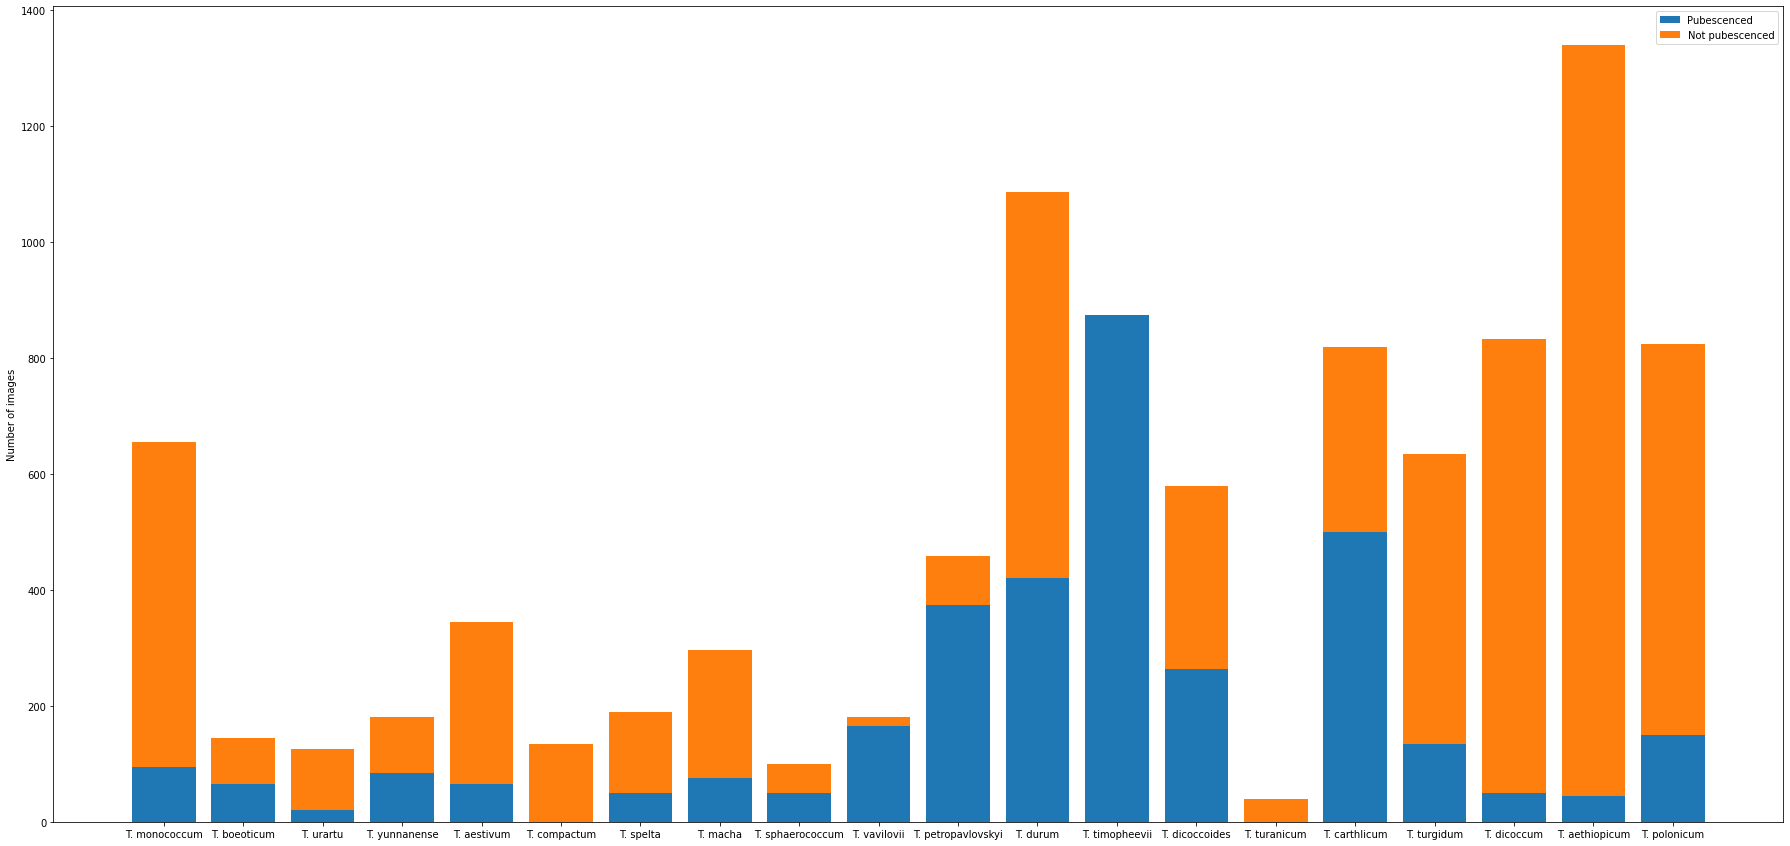

In [15]:
labels = spec_dist.keys()
pubesc = [x[1] for x in spec_dist.values()]
non_pubesc = [x[0] for x in spec_dist.values()]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(31,15))

ax.bar(labels, pubesc, label='Pubescenced')
ax.bar(labels, non_pubesc, bottom=pubesc, label='Not pubescenced')

ax.set_ylabel('Number of images')
ax.legend()

plt.show()
fig.savefig(h_dir + '/hyst_pub.png')

### Step 4: Splitting algorithm (non-optimal enumeration)

In [16]:
import itertools

# If necessary I will add:
# key_type - type of minimum, that we are searching
#
# key_type == 'sample_min' means, that we are searching split to minimize
# sample mean
#
# key_type == 'defaul' means, that we are searching split to minimize
# max difference between subsamples into the split

def get_optimal_split():
    k = sum_non_pubesc / sum_pubesc
    s = sum_pubesc + sum_non_pubesc
    print('Optimal k:', k)
    print('Sum of all images:', s, '\n')
    
    # 1. consider and store all possible sample splits
    info = [(key, spec_dist[key]) for key in spec_dist]
    splits = []
    
    all_pos = list(range(1, len(info)))
    for pos in itertools.combinations(all_pos, 2):
        tmp = []
        prev_idx = 0
        for curr_idx in pos:
            tmp.append(info[prev_idx:curr_idx])
            prev_idx = curr_idx
        tmp.append(info[curr_idx:])
        splits.append(tmp)

    # 2. for each split - compute k and number of images
    # format of data: [[% of overall imgs, k], [], []]
    coefficients = []
    for spl in splits:
        tmp = []
        for sample in spl:
            tmp_s_pubesc = 0
            tmp_s_non_pubesc = 0
            for elem in sample:
                tmp_s_pubesc += elem[1][1] 
                tmp_s_non_pubesc += elem[1][0]
            if tmp_s_pubesc == 0:
                tmp_s_pubesc = 0.1
            tmp.append( ((tmp_s_pubesc + tmp_s_non_pubesc)/s, tmp_s_non_pubesc / tmp_s_pubesc) )
        coefficients.append(tmp)
    
    # return coefficients
    res1 = []
    # 3. finding optimal split by sequential sifting
    
    # 3.1 sifting by percentage of overall images
    for i, data in enumerate(coefficients):
        data = sorted(data, key=lambda data: data[0], reverse=True)
        if (not (0.9 > data[0][0] > 0.7)) or (not (0.2 > data[1][0] > 0.05)) or (not (0.2 > data[2][0] > 0.05)):
            continue
        else:
            res1.append((i, data))

    idx = 0
    min_k = 100
    # 3.2 find the minimum of difference between predefined k and k of the split
    for i, data in res1:
        k1 = data[0][1]
        k2 = data[1][1]
        k3 = data[2][1]
        if max(abs(k1-k2),abs(k3-k2),abs(k1-k3)) < min_k:
            idx = i
            min_k = max(abs(k1-k2),abs(k3-k2),abs(k1-k3))
    
    # 4. form sample from optimal idx
    final = sorted(splits[idx], reverse=True)
    for i in range(3):
        final[i] = [x[0] for j,x in enumerate(final[i])]
    train = final[0]
    valid = final[1]
    test = final[2]
    return (train, valid, test)

In [17]:
train, test, valid = get_optimal_split()

Optimal k: 1.82548794489093
Sum of all images: 9844 



In [18]:
print(f'Train split: {train}', end='\n\n')
print(f'Valid split: {valid}', end='\n\n')
print(f'Test split: {test}', end='\n\n')

Train split: ['T. petropavlovskyi', 'T. durum', 'T. timopheevii', 'T. dicoccoides', 'T. turanicum', 'T. carthlicum', 'T. turgidum', 'T. dicoccum', 'T. aethiopicum', 'T. polonicum']

Valid split: ['T. aestivum', 'T. compactum', 'T. spelta', 'T. macha', 'T. sphaerococcum', 'T. vavilovii']

Test split: ['T. monococcum', 'T. boeoticum', 'T. urartu', 'T. yunnanense']



### Step 4: Create file with images, lables and samples name

In [19]:
    # first split
# test = ['T. boeoticum', 'T. vavilovii', 'T. polonicum']
# valid = ['T. macha', 'T. dicoccoides']
    
    # second split
# test = ['T. petropavlovskyi', 'T. monococcum', 'T. turanicum']
# valid = ['T. durum', 'T. yunnanense']

    # third split
# test = ['T. yunnanense', 'T. urartu', 'T. boeoticum', 'T. macha', 'T. sphaerococcum', 'T. spelta']
# valid = ['T. durum']

In [20]:
labelled_dist = {key: [0, 0] for key in (valid+test+train)}

In [21]:
# Used for extract species for training
    
def create_file(train, test, valid, name='data_split'):
    def get_label(img_path):
        subspec_patt = r'\d{2,5}-?(\d{2,5})?'
        spec_patt = r'T\.\s\w*'
        veg_patt = r'(Х|X|I){1,2}-?\d{2}'
        # get name of subspecies and species
        subspec = re.search(subspec_patt, img_path).group()
        spec = re.search(spec_patt, img_path).group()
        veg = ''
        if re.search(veg_patt, img_path):
            veg = re.search(veg_patt, img_path).group()
            
        # get the label according to species and subspecies
        df = pd.read_csv('/home/jupyter-n.artemenko/projects/spikelet_pubescence/labels.csv')
        tmp1 = df.loc[df['Вид'] == spec]
        tmp2 = tmp1.loc[tmp1['Порядковые_номера'].str.contains(subspec)]
        
        # there are subspecies without any labels
        if not tmp2.empty:
            label = int(tmp2.iloc[0]['Опушение'])
            labelled_dist[spec][label] += 1
            return label
        else:
            return None
    
    def get_sample(img_path):
        spec_patt = r'T.\s\w*'
        res = re.search(spec_patt, img_path).group()
        if res in train:
            return 'train'
        if res in valid:
            return 'valid'
        if res in test:
            return 'test'
        return None
    
    
    out = open(name, 'w')
    h_dir = '/data/cv_project/spikedroid/ploid_classification'
    
    # patterns for images
    pin_patt = r'\d{2,5}_(([^,(I|l)]_\{[ХXI]{1,2}-?\d{2,4}\})|(\d{1}))\.(jpg|JPG)$'
    table_patt = r'\d{2,5}(_\{[ХXI]{1,2}-?\d{2,4}\})?\.(jpg|JPG)$'
    for dirpath, dirnames, filenames in os.walk(h_dir):
        for fn in filenames:
            res1 = re.search(pin_patt, fn)
            res2 = re.search(table_patt, fn)
            if res1 or res2:
                # choose one not none value
                res = ''
                if res1:
                    res = res1
                else:
                    res = res2
                part1 = dirpath+'/'+res.group()
                part2 = str(get_label(dirpath+'/'+fn))
                part3 = get_sample(dirpath)
                if part2 != 'None':
                    # print(part1+' '+part2+' '+part3)
                    out.write(part1+';'+part2+';'+part3+'\n')
    out.close()

In [22]:
create_file(train, test, valid, name='optimal_split.txt')

### EDA of used data in the project (less than overall data for about 200 images)

In [23]:
for key in labelled_dist:
    print(key, labelled_dist[key])

T. aestivum [280, 65]
T. compactum [135, 0]
T. spelta [140, 50]
T. macha [220, 76]
T. sphaerococcum [50, 50]
T. vavilovii [0, 165]
T. monococcum [560, 95]
T. boeoticum [80, 65]
T. urartu [105, 20]
T. yunnanense [95, 85]
T. petropavlovskyi [0, 374]
T. durum [812, 275]
T. timopheevii [0, 875]
T. dicoccoides [315, 264]
T. turanicum [0, 0]
T. carthlicum [320, 500]
T. turgidum [500, 90]
T. dicoccum [783, 50]
T. aethiopicum [1255, 45]
T. polonicum [775, 50]


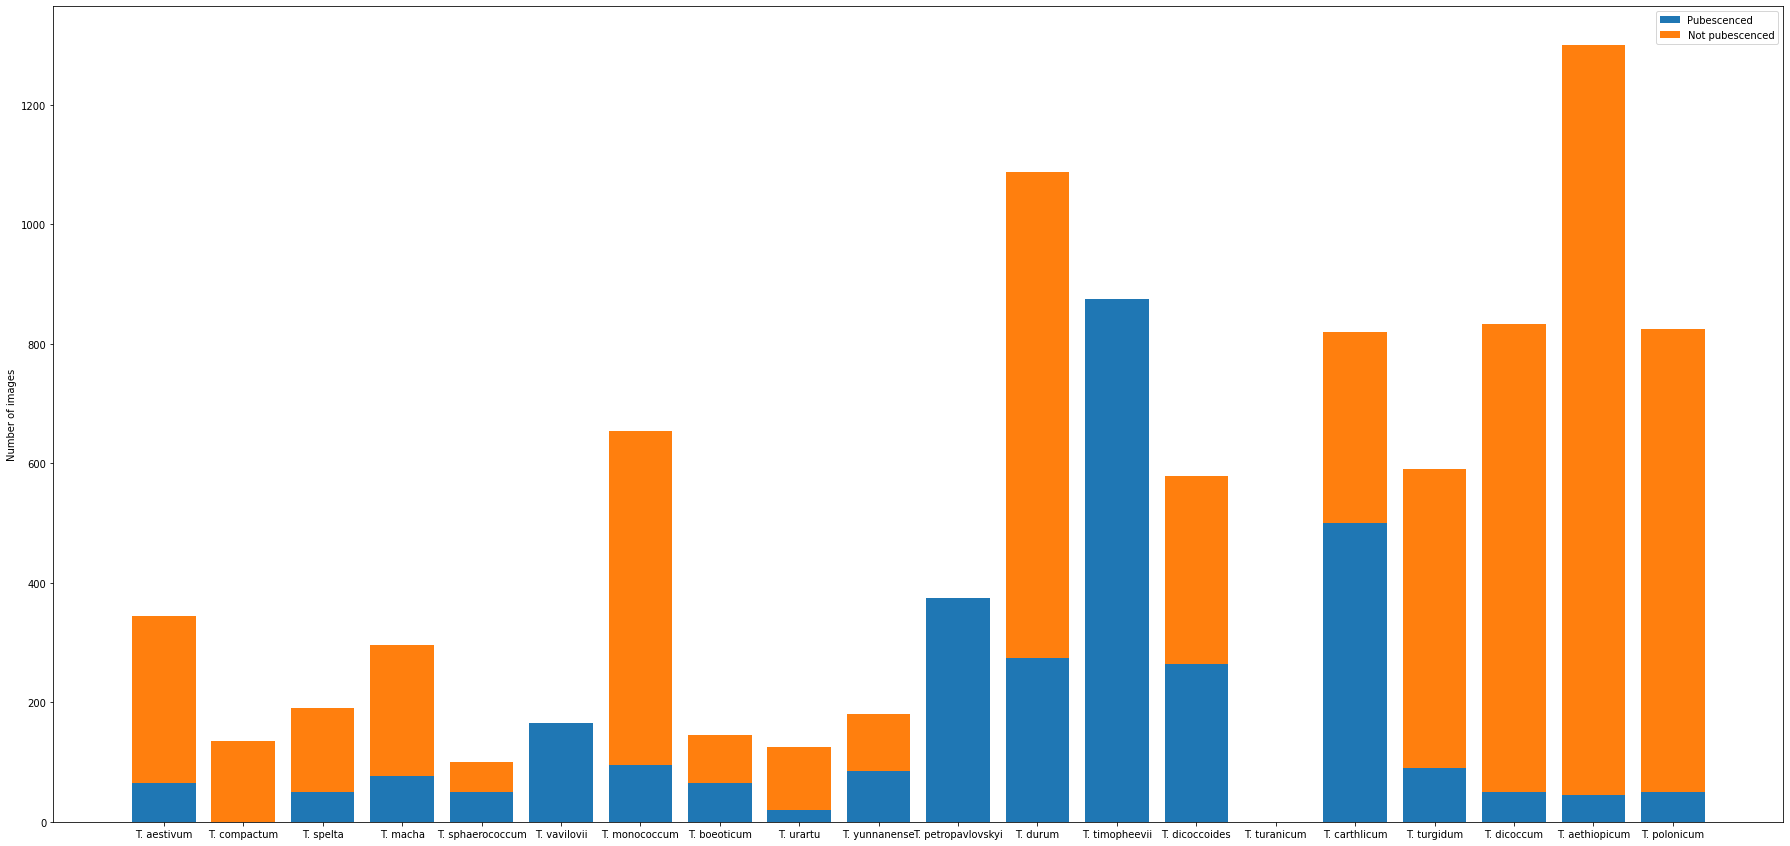

In [24]:
labels = labelled_dist.keys()
pubesc = [x[1] for x in labelled_dist.values()]
non_pubesc = [x[0] for x in labelled_dist.values()]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(31,15))

ax.bar(labels, pubesc, label='Pubescenced')
ax.bar(labels, non_pubesc, bottom=pubesc, label='Not pubescenced')

ax.set_ylabel('Number of images')
ax.legend()

plt.show()
fig.savefig(h_dir + '/actual_data_pub.png')